## HW 5.0
What is a data warehouse? What is a Star schema? When is it used?

## HW 5.1
In the database world What is 3NF? Does machine learning use data in 3NF? If so why?   
In what form does ML consume data?  
Why would one use log files that are denormalized?  


## HW 5.2

Using MRJob, implement a hashside join (memory-backed map-side) for left, right and inner joins. 

Run your code on the data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file)). 

In this output please include the webpage URL, webpageID and Visitor ID.:

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

1. Left joining Table Left with Table Right
2. Right joining Table Left with Table Right
3. Inner joining Table Left with Table Right



In [9]:
%load_ext autoreload
%autoreload 2

In [24]:
%%writefile MRJoin_5_2.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

class MRJoin(MRJob):
    urls = {} # key = pageId, value = url
    keys_emitted = set() # Set of keys of all emitted urls. Used for left join.
    
    def configure_options(self):
        super(MRJoin, self).configure_options()
        self.add_passthrough_option(
            '--joinType', type='str', default="inner")
        
    def load_options(self, args):
        super(MRJoin, self).load_options(args)
        self.joinType = self.options.joinType
        
    def mapper_init(self):
        # Load URL info data file into memory.  
        # Line format: 
        # 1287,/autoroute
        with open("processed_urls.data", "r") as f:
            for fields in csv.reader(f):
                self.urls[fields[0]] = fields[1]

    def mapper(self, line_no, line):
        # Line format: 
        # V,1000,1,C,10001
        fields = csv.reader([line]).next()
        
        key = fields[1]
        url = None
        toEmit = False
        
        if key in self.urls:
            url = self.urls[key]
            
        if self.joinType == "right":
            toEmit = True
        elif self.joinType == "left":
            if url is not None:
                toEmit = True
                self.keys_emitted.add(key) # Remember what we have emitted
        else: # inner join
            if url is not None:
                toEmit = True
        
        if toEmit:
            # Output format
            # pageid, url,V,1,C,10001
            yield key, (url, fields[0], fields[2], fields[3], fields[4])
        
    def mapper_final(self):
        if self.joinType == "left":
            # Emit all the remaining urls
            remaining = set(self.urls.keys()) - self.keys_emitted
            for key in remaining:
                yield key, (self.urls[key], None, None, None, None)
                                
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   mapper_final=self.mapper_final)
            ]
    
if __name__ == '__main__':
    MRJoin.run()


Overwriting MRJoin_5_2.py


In [27]:
from MRJoin_5_2 import MRJoin

for joinType in ["left", "right", "inner"]:
    mr_job = MRJoin(args=['processed_anonymous-msweb.data', 
                        '--file', 'processed_urls.data', # broadcast to every mapper
                        "--strict-protocols",
                        '--joinType', joinType])

    with mr_job.make_runner() as runner: 
        runner.run()

        lines = []
        for line in runner.stream_output():
            lines.append(line)
            
        print "Join type:" + joinType
        print "Number of records:" + str(len(lines))
        print "First 5 lines:"
        for i in range(5):
            print lines[i].strip()
            
        print


Join type:left
Number of records:98663
First 5 lines:
"1000"	["/regwiz", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10001"]
"1002"	["/athome", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10002"]
"1003"	["/kb", "V", "1", "C", "10002"]

Join type:right
Number of records:98654
First 5 lines:
"1000"	["/regwiz", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10001"]
"1002"	["/athome", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10002"]
"1003"	["/kb", "V", "1", "C", "10002"]

Join type:inner
Number of records:98654
First 5 lines:
"1000"	["/regwiz", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10001"]
"1002"	["/athome", "V", "1", "C", "10001"]
"1001"	["/support", "V", "1", "C", "10002"]
"1003"	["/kb", "V", "1", "C", "10002"]



## HW 5.3  EDA of Google n-grams dataset
For the Google n-grams dataset unit test and regression test your code using the 
first 10 lines of the following file:  
``googlebooks-eng-all-5gram-20090715-0-filtered.txt``

Finally show your results on the Google n-grams dataset. 

In particular, this bucket contains (~200) files (10Meg each) in the format:

``	(ngram) \t (count) \t (pages_count) \t (books_count)``

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (please use the count information), i.e., unigrams
- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.


In [2]:
%load_ext autoreload
%autoreload 2

### HW5.3a

Find Longest 5-gram (number of characters)


In [58]:
%%writefile MrLongest_5_3a.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

# Find Longest 5-gram (number of characters)
class MrLongest(MRJob):
    def mapper(self, line_no, line):
        # Line format: 
        # (ngram) \t (count) \t (pages_count) \t (books_count)
        fields = csv.reader([line], delimiter='\t').next()        
        ngram = fields[0]
        yield len(ngram), ngram

    def reducer_init(self):
        self.emitted = False
        
    def reducer(self, length, values):
        # We only need to emit the first one, which is the longest for this reducer
        if not self.emitted:
            self.emitted = True
            ngrams = [ngram for ngram in values]
            yield length, ngrams
                                
    def steps(self):
        return [
            MRStep(
                mapper=self.mapper,
                reducer_init=self.reducer_init,
                reducer=self.reducer,
                # First key is length; sort it in reverse order
                jobconf={
                    "stream.num.map.output.key.fields":"1",
                    "mapred.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapred.text.key.comparator.options":"-k1,1nr"
                          }                
                  )
            ]
    
if __name__ == '__main__':
    MrLongest.run()


Overwriting MrLongest_5_3a.py


#### Unit Tests

In [33]:
# Prepare test file
!head -n 10 googlebooks-eng-all-5gram-20090715-0-filtered.txt > testData.txt

In [83]:
%%writefile unitTest_5_3a.py
import unittest
from MrLongest_5_3a import MrLongest

class UnitTest_5_3(unittest.TestCase):
    
    def __init__(self, *args, **kwargs):
        super(UnitTest_5_3, self).__init__(*args, **kwargs)
        with open('testData.txt', 'r') as f:
            self.first_line = f.readline()
            self.first_ngram = self.first_line.split('\t')[0]
        
    def test_MrLongest_mapper(self):
        j = MrLongest()
        self.assertEqual(j.mapper(None, self.first_line).next(), 
                         (len(self.first_ngram), self.first_ngram))
        
    def test_MrLongest_reducer(self):
        j = MrLongest()
        ngrams = ["0123456789", "A12345678B"]
        length = len(ngrams[0])
        
        j.reducer_init()
        self.assertEqual(j.reducer(length, ngrams).next(), (length, ngrams))

        # We only output the first one.
        with self.assertRaises(StopIteration):
            j.reducer(length, ngrams).next()
        
if __name__ == '__main__':
    unittest.main()

Writing unitTest_5_3a.py


In [84]:
!python unitTest_5_3a.py

..
----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


#### Full test

In [81]:
%%writefile fullTest_5_3.py
import unittest
from MrLongest_5_3a import MrLongest

class FullTest_5_3a(unittest.TestCase):

    def test_full(self):
        mr_job = MrLongest(
            args=['testData.txt', 
                  # Have to use Hadoop, otherwise custom sort order won't work.
                  '-r', 'hadoop', 
                  '--strict-protocols',
                  # so options from local mrjob.conf don't pollute the test env.
                  '--no-conf', 
                 ])

        results = []
        with mr_job.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                # Use the job's specified protocol to read the output
                key, value = mr_job.parse_output_line(line)
                results.append((key, value))

        self.assertEqual(len(results), 1)
        self.assertEqual(results[0], 
                (33, ['A Circumstantial Narrative of the', 'A BILL FOR ESTABLISHING RELIGIOUS']))

if __name__ == '__main__':
    unittest.main()

Overwriting fullTest_5_3.py


In [82]:
!python fullTest_5_3.py

No handlers could be found for logger "mrjob.compat"
.
----------------------------------------------------------------------
Ran 1 test in 37.503s

OK


### Try it on a local hadoop, using just one data file

In [92]:
!python MrLongest_5_3a.py \
googlebooks-eng-all-5gram-20090715-0-filtered.txt \
--jobconf mapred.map.tasks=3 --jobconf mapred.reduce.tasks=1 \
-r hadoop \
--strict-protocols

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrLongest_5_3a.patrickng.20160215.110146.825546
writing wrapper script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrLongest_5_3a.patrickng.20160215.110146.825546/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/patrickng/tmp/mrjob/MrLongest_5_3a.patrickng.20160215.110146.825546/files/
Detected hadoop configuration property names that do not match hadoop version 2.7.1:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.reduce.tasks: mapreduce.job.reduces
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
HADOOP: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
HADOOP: packageJobJar: [/v

### Run it for real on EMR, using all data files

In [94]:
!python MrLongest_5_3a.py \
s3://filtered-5grams/ \
--jobconf mapred.map.tasks=28 --jobconf mapred.reduce.tasks=1 \
-r emr \
--ec2-instance-type m1.xlarge \
--num-ec2-instances 4 \
--emr-tag job=hw5_3a \
--strict-protocols

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
using existing scratch bucket mrjob-2c54d3a4b9812930
using s3://mrjob-2c54d3a4b9812930/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrLongest_5_3a.patrickng.20160215.111635.198877
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrLongest_5_3a.patrickng.20160215.111635.198877/b.py
Copying non-input files into s3://mrjob-2c54d3a4b9812930/tmp/MrLongest_5_3a.patrickng.20160215.111635.198877/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-2X8QEUZQA1863
Setting EMR tags: job=hw5_3a
Created new job flow j-2X8QEUZQA1863
Job launched 32.7s ago, status S

#### Answer
Longest 5-gram:  
Length = 159	

"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"  

"ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT"

### HW5.3b

Top 10 most frequent words (please use the count information), i.e., unigrams


In [128]:
%%writefile MrFrequent_5_3b.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

# Top 10 most frequent words (please use the count information), i.e., unigrams
class MrFrequent(MRJob):
    emitted = 0
    
    def word_count_mapper(self, line_no, line):
        # Line format: 
        # (ngram) \t (count) \t (pages_count) \t (books_count)
        fields = csv.reader([line], delimiter='\t').next()        
        count = int(fields[1])
        
        for word in fields[0].split():
            yield word, count

    def sum_word_count_reducer(self, key, counts):
        yield key, sum([count for count in counts])
        
    def mapper(self, key, line):
        yield key, line
    
    def top10_words_reducer(self, key, counts):
        if self.emitted < 10:
            self.emitted += 1
            yield key, counts.next()
                                
    def steps(self):
        return [
            MRStep(
                mapper=self.word_count_mapper,
                combiner=self.sum_word_count_reducer,
                reducer=self.sum_word_count_reducer,
                jobconf={
                    "mapred.map.tasks":28,
                    "mapred.reduce.tasks":28
                    }
                ),
            MRStep(
                reducer=self.top10_words_reducer,
                jobconf={
                    "stream.num.map.output.key.fields":"2",
                    "mapred.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapred.text.key.comparator.options":"-k2,2nr",
                    "mapred.map.tasks":28,
                    "mapred.reduce.tasks":1
                          }                
                )
            ]
    
if __name__ == '__main__':
    MrFrequent.run()


Overwriting MrFrequent_5_3b.py


In [104]:
%%writefile unitTest_5_3b.py
import unittest
from MrFrequent_5_3b import MrFrequent

class UnitTest_5_3b(unittest.TestCase):
    
    def __init__(self, *args, **kwargs):
        super(UnitTest_5_3b, self).__init__(*args, **kwargs)
        with open('testData.txt', 'r') as f:
            self.first_line = f.readline()
            fields = self.first_line.split('\t')
            self.first_ngram = fields[0]
            self.count = int(fields[1])
            self.first_words = self.first_ngram.split()
        
    def test_MrFrequent_mapper1(self):
        j = MrFrequent()
        self.assertEqual(j.word_count_mapper(None, self.first_line).next(), 
                         (self.first_words[0], self.count))
                
if __name__ == '__main__':
    unittest.main()

Overwriting unitTest_5_3b.py


In [105]:
!python unitTest_5_3b.py

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


#### Try it on local hadoop, using one data file

In [129]:
!python MrFrequent_5_3b.py \
googlebooks-eng-all-5gram-20090715-0-filtered.txt \
-r hadoop 

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrFrequent_5_3b.patrickng.20160215.122152.986329
writing wrapper script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrFrequent_5_3b.patrickng.20160215.122152.986329/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/patrickng/tmp/mrjob/MrFrequent_5_3b.patrickng.20160215.122152.986329/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Detected hadoop configuration property names that do not match hadoop version 2.7.1:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
mapred.reduce.tasks: mapreduce.job.reduces
HADOOP: Unable to load native-hadoop librar

In [130]:
!python MrFrequent_5_3b.py \
s3://filtered-5grams/ \
-r emr \
--ec2-instance-type m1.xlarge \
--num-ec2-instances 5 \
--emr-tag job=hw5_3a

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
using existing scratch bucket mrjob-2c54d3a4b9812930
using s3://mrjob-2c54d3a4b9812930/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrFrequent_5_3b.patrickng.20160215.122952.205418
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrFrequent_5_3b.patrickng.20160215.122952.205418/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-2c54d3a4b9812930/tmp/MrFrequent_5_3b.patrickng.20160215.122952.205418/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying defa

#### Answer

Top 10 frequent words (word, count):  
"the"	5375699242  
"of"	3691308874  
"to"	2221164346  
"in"	1387638591  
"a"	1342195425  
"and"	1135779433  
"that"	798553959  
"is"	756296656  
"be"	688053106  
"as"	481373389  

## HW5.3c

20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 


In [172]:
%%writefile MrDensity_5_3c.py
from __future__ import division
from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

# 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing 
# order of relative frequency 
class MrDensity(MRJob):
    emitted = 0
    
    def word_count_mapper(self, line_no, line):
        # Line format: 
        # (ngram) \t (count) \t (pages_count) \t (books_count)
        fields = csv.reader([line], delimiter='\t').next()        
        count = int(fields[1])
        page_count = int(fields[2])
        
        for word in fields[0].split():
            yield word, (count, page_count)

    def get_density_reducer(self, key, values):
        # Sum up the count and the page_count
        (count_total, page_count_total) = reduce(lambda x,y: (x[0]+y[0], x[1]+y[1]), values)
        yield key, count_total/page_count_total # density
        
    def sort_density_reducer(self, key, values):
        yield key, values.next()
                                
    def steps(self):
        return [
            MRStep(
                mapper=self.word_count_mapper,
                reducer=self.get_density_reducer,
                jobconf={
                    "mapred.job.name":"MrDensity-step1",
                    "mapreduce.job.maps":35,
                    "mapreduce.job.reduces":35
                    }
                ),
            
            MRStep(
                reducer=self.sort_density_reducer,
                jobconf={
                    "mapred.job.name":"MrDensity-step2",
                    "stream.num.map.output.key.fields":"2",
                    "mapred.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapred.text.key.comparator.options":"-k2,2nr",
                    "mapreduce.job.maps":35,
                    "mapreduce.job.reduces":1
                          }                
                )


            ]
    
if __name__ == '__main__':
    MrDensity.run()


Overwriting MrDensity_5_3c.py


#### Run it on local hadoop using one data file

In [169]:
!python MrDensity_5_3c.py \
googlebooks-eng-all-5gram-20090715-0-filtered.txt \
-r hadoop \
> hw_5_3c.result

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDensity_5_3c.patrickng.20160215.145730.477553
writing wrapper script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDensity_5_3c.patrickng.20160215.145730.477553/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/patrickng/tmp/mrjob/MrDensity_5_3c.patrickng.20160215.145730.477553/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Detected hadoop configuration property names that do not match hadoop version 2.7.1:
The have been translated as follows
 mapred.job.name: mapreduce.job.name
HADOOP: Unable to load native-hadoop library for your platform... using builtin-java class

In [170]:
!head -n 20 hw_5_3c.result

"lak"	3.072289156626506
"Honourable"	2.8927536231884057
"Expiration"	2.510204081632653
"operand"	2.353448275862069
"bust"	2.3493975903614457
"houseless"	2.274891774891775
"Gynecological"	2.2481536189069424
"denatured"	2.1864406779661016
"Saving"	2.1129032258064515
"Phe"	2.0408163265306123
"Pathology"	2.021301775147929
"Kiowa"	2.0
"apiece"	1.9607843137254901
"unreachable"	1.9433962264150944
"theres"	1.9230769230769231
"Rumanian"	1.904320987654321
"traitorously"	1.8928571428571428
"pilage"	1.8333333333333333
"Dock"	1.8028169014084507
"aristocrat"	1.7906976744186047


In [171]:
!tail -n 20 hw_5_3c.result

"Absolutist"	1.0
"Ability"	1.0
"Aberdeen"	1.0
"Abdul"	1.0
"Abbotsford"	1.0
"Abbot's"	1.0
"Abbot"	1.0
"Aalborg"	1.0
"AUDACIOUS"	1.0
"zebra"	1.0
"zeolite"	1.0
"zest"	1.0
"AMERICAN"	1.0
"AMERICA"	1.0
"AMAZON"	1.0
"AE"	1.0
"zodiac"	1.0
"nooks"	1.0
"nontrivial"	1.0
"nonsuit"	1.0


#### Run it on EMR

In [173]:
!python MrDensity_5_3c.py \
s3://filtered-5grams/ \
-r emr \
--ec2-instance-type m1.xlarge \
--num-ec2-instances 6 \
--emr-tag job=hw5_3c \
> hw_5_3c-emr.result

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
using existing scratch bucket mrjob-2c54d3a4b9812930
using s3://mrjob-2c54d3a4b9812930/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDensity_5_3c.patrickng.20160215.150403.990340
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDensity_5_3c.patrickng.20160215.150403.990340/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-2c54d3a4b9812930/tmp/MrDensity_5_3c.patrickng.20160215.150403.990340/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default

#### Answers
20 most dense and 20 least dense words

In [174]:
!head -n 20 hw_5_3c-emr.result

"xxxx"	11.557291666666666
"NA"	10.161726044782885
"blah"	8.0741599073001158
"nnn"	7.5333333333333332
"nd"	6.5611436445056839
"ND"	5.4073642846747196
"oooooooooooooooo"	4.921875
"PIC"	4.7272727272727275
"llll"	4.5116279069767442
"LUTHER"	4.3494983277591972
"oooooo"	4.2072378595731514
"NN"	4.0908402725208175
"ooooo"	3.9492846924177396
"OOOOOO"	3.9313725490196076
"IIII"	3.7877030162412995
"lillelu"	3.7624521072796937
"OOOOO"	3.6570701447431206
"Sc"	3.6065624999999999
"Pfeffermann"	3.5769230769230771
"Madarassy"	3.5769230769230771


In [175]:
!tail -n 20 hw_5_3c-emr.result

"AAN"	1.0
"yallowchy"	1.0
"yeelding"	1.0
"yeers"	1.0
"yelloch"	1.0
"yemen"	1.0
"yerne"	1.0
"yestermorn"	1.0
"yleisen"	1.0
"ymounted"	1.0
"yont"	1.0
"youngster's"	1.0
"yproved"	1.0
"zamarra"	1.0
"zein"	1.0
"zeles"	1.0
"zeugmatographic"	1.0
"zoosperms"	1.0
"zuletzt"	1.0
"GOKHALE"	1.0


### HW5.3d

Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

In [218]:
%%writefile MrDistribution_5_3d.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

# Distribution of 5-gram sizes (character length). E.g., count (using the count field) 
# up how many times a 5-gram of 50 characters shows up.
class MrDistribution(MRJob):
    def length_count_mapper(self, line_no, line):
        # Line format: 
        # (ngram) \t (count) \t (pages_count) \t (books_count)
        fields = csv.reader([line], delimiter='\t').next()        
        ngram = fields[0]
        yield len(ngram), 1

    def length_sum_reducer(self, length, values):
        yield length, sum([v for v in values])
        
    def length_sort_reducer(self, length, values):
        yield length, values.next()
        
    def steps(self):
        return [
            MRStep(
                mapper=self.length_count_mapper,
                combiner=self.length_sum_reducer,
                reducer=self.length_sum_reducer,
                jobconf={
                    "mapred.job.name":"MrDistribution-step1",
                    "mapreduce.job.maps":21,
                    "mapreduce.job.reduces":21
                    }
                  ),
            MRStep(
                reducer=self.length_sort_reducer,
                jobconf={
                    "mapred.job.name":"MrDistribution-step2",
                    "stream.num.map.output.key.fields":"1",
                    "mapred.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapred.text.key.comparator.options":"-k1,1n",
                    "mapreduce.job.maps":21,
                    "mapreduce.job.reduces":1
                          }                
                )
            ]
    
if __name__ == '__main__':
    MrDistribution.run()


Overwriting MrDistribution_5_3d.py


#### Run it using local hadoop on one data file

In [183]:
!python MrDistribution_5_3d.py \
googlebooks-eng-all-5gram-20090715-0-filtered.txt \
-r hadoop

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDistribution_5_3d.patrickng.20160215.155756.872061
writing wrapper script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDistribution_5_3d.patrickng.20160215.155756.872061/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/patrickng/tmp/mrjob/MrDistribution_5_3d.patrickng.20160215.155756.872061/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
HADOOP: packageJobJar: [/var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/hadoop-unjar4375792671918037377/] [] /var/folders/

#### Run it on EMR

In [220]:
!python MrDistribution_5_3d.py \
s3://filtered-5grams/ \
-r emr \
--ec2-instance-type m1.xlarge \
--num-ec2-instances 4 \
--emr-tag job=hw5_3d \
> hw_5_3d-emr.result

Got unexpected keyword arguments: ssh_tunnel
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
using existing scratch bucket mrjob-2c54d3a4b9812930
using s3://mrjob-2c54d3a4b9812930/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDistribution_5_3d.patrickng.20160215.163351.813491
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrDistribution_5_3d.patrickng.20160215.163351.813491/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-2c54d3a4b9812930/tmp/MrDistribution_5_3d.patrickng.20160215.163351.813491/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API,

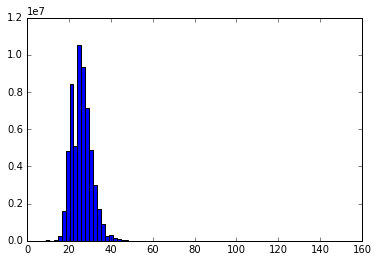

In [224]:
%matplotlib inline
import matplotlib.pyplot as plt

import csv

data = {}
with open("hw_5_3d-emr.result", "r") as f:
    for fields in csv.reader(f, delimiter="\t"):
        data[int(fields[0])] = int(fields[1])
        
c,b,ax = plt.hist(data.keys(), weights=data.values(), bins=80)

In [190]:
len(data.keys())

49

In [189]:
len(data.values())

49